# Assignment CNNs - Part 2: Transfer Learning Strategies with Fast Food Classification


In this notebook, we will:
1. Import and prepare the Fast Food Classification dataset
2. Implement three different transfer learning strategies:
   - Feature extraction (frozen pre-trained model)
   - Fine-tuning last few layers
   - Full fine-tuning
3. Get experience on how sample size affects the strategy's performance
4. Get experience of the impact of choosing the right/wrong learning rate
5. Get experience with the different transfer learning strategies

## 0. Introduction

Transfer learning is a powerful technique that allows us to leverage pre-trained models for new tasks. However, different transfer learning strategies are suitable for different scenarios, particularly depending on:
- Sample size of the target dataset
- Similarity between source and target tasks
- Available computational resources

In this exercise, we'll explore different transfer learning strategies using the "Fast Food Classification Dataset - V2" from Kaggle.

## 1. Data Import and Cleaning

1. Download the ["Fast Food Classification Dataset - V2"](https://www.kaggle.com/datasets/utkarshsaxenadn/fast-food-classification-dataset/data) from Kaggle.

2. Unzip and ensure that the dataset in Colab is structured as follows:

```
|
|-- Fast Food Classification V2
|   |-- TFRecords
|   |-- Test
|   |-- Train
|   `-- Valid
|-- sample_data
`-- archive.zip
```

`Fast Food Classification V2` and `archive.zip` should be on the same level as the already existing `sample_data` directory from Colab. You can ignore the `TFRecords` subdirectory in the following tasks.

In [ ]:
#!/bin/bash
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/utkarshsaxenadn/fast-food-classification-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  820M  100  820M    0     0  17.5M      0  0:00:46  0:00:46 --:--:-- 18.8M


In [ ]:
!unzip -q archive.zip

3. Apply the provided `delete_invalid_images` function to check and remove any corrupted or invalid images in each of the three dataset directories.

In [ ]:
import os
from PIL import Image

# Define the paths to the directories
directories = [
    "Train",
    "Valid",
    "Test"
]

# Define supported image file extensions
supported_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}

def delete_invalid_images(directory):
    """Goes through a directory and deletes any invalid or unsupported images."""
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Check if the file has a supported extension
            if not any(file.lower().endswith(ext) for ext in supported_extensions):
                print(f"Deleting unsupported file: {file_path}")
                os.remove(file_path)
                continue

            try:
                with Image.open(file_path) as img:
                    img.load()  # Ensure the image content can be read
                    if img.format not in ["JPEG", "PNG", "GIF", "BMP"]:
                        raise IOError("Unsupported image format")
            except (IOError, SyntaxError, AttributeError) as e:
                print(f"Deleting invalid or corrupted image: {file_path}")
                os.remove(file_path)

# Run the function for each directory
for dir_path in directories:
    delete_invalid_images(dir_path)

print("Invalid and unsupported image cleanup completed.")

Invalid and unsupported image cleanup completed.


4. To reduce training time, only three classes are considered for the following training.

In [ ]:
# prompt: In each of the Train, Test, and Valid folder in the folder "Fast Food Classification V2" that were just unzipped, only keep the folders Taquito, Crispy Chicken, and Donut. Remove the others.

import os
import shutil

# Define the root directory of the dataset
dataset_root = "Fast Food Classification V2"

# Define the subdirectories (Train, Test, Valid)
subdirectories = ["Train", "Test", "Valid"]

# Define the classes to keep
classes_to_keep = ["Pizza", "Hot Dog", "Burger"]

# Loop through each subdirectory
for subdir in subdirectories:
  subdir_path = os.path.join(dataset_root, subdir)

  # Loop through each folder (class) in the subdirectory
  for class_folder in os.listdir(subdir_path):
    class_folder_path = os.path.join(subdir_path, class_folder)

    # Check if it's a directory and if it's not one of the classes to keep
    if os.path.isdir(class_folder_path) and class_folder not in classes_to_keep:
      print(f"Removing folder: {class_folder_path}")
      shutil.rmtree(class_folder_path)

print("Folder cleanup completed.")

Removing folder: Fast Food Classification V2/Train/Crispy Chicken
Removing folder: Fast Food Classification V2/Train/Fries
Removing folder: Fast Food Classification V2/Train/Baked Potato
Removing folder: Fast Food Classification V2/Train/Taquito
Removing folder: Fast Food Classification V2/Train/Sandwich
Removing folder: Fast Food Classification V2/Train/Taco
Removing folder: Fast Food Classification V2/Train/Donut
Removing folder: Fast Food Classification V2/Test/Crispy Chicken
Removing folder: Fast Food Classification V2/Test/Fries
Removing folder: Fast Food Classification V2/Test/Baked Potato
Removing folder: Fast Food Classification V2/Test/Taquito
Removing folder: Fast Food Classification V2/Test/Sandwich
Removing folder: Fast Food Classification V2/Test/Taco
Removing folder: Fast Food Classification V2/Test/Donut
Removing folder: Fast Food Classification V2/Valid/Crispy Chicken
Removing folder: Fast Food Classification V2/Valid/Fries
Removing folder: Fast Food Classification V2/V

### Creation of Different Training Dataset Sizes

   - Small: 50 images per class
   - Medium: 200 images per class  
   - Full: All available training images

To reduce training time, only three classes are considered in the training.

The validation and test sets will remain constant to ensure fair comparison.

In [ ]:
import os
import numpy as np
import shutil
from pathlib import Path

# Constants
SMALL_SAMPLES = 50  # images per class
MEDIUM_SAMPLES = 200 # images per class

def create_sample_dataset(source_dir, target_dir, samples_per_class):
    """Creates a smaller dataset by randomly sampling from source directory"""
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    # Create target directory
    os.makedirs(target_dir)

    # For each class directory
    for class_dir in os.listdir(source_dir):
        source_class_path = os.path.join(source_dir, class_dir)
        target_class_path = os.path.join(target_dir, class_dir)

        if os.path.isdir(source_class_path):
            # Create class directory in target
            os.makedirs(target_class_path)

            # Get list of all images
            images = os.listdir(source_class_path)

            # Randomly sample specified number of images
            selected_images = np.random.choice(
                images,
                size=min(samples_per_class, len(images)),
                replace=False
            )

            # Copy selected images
            for img in selected_images:
                shutil.copy2(
                    os.path.join(source_class_path, img),
                    os.path.join(target_class_path, img)
                )

# Create sampled datasets
create_sample_dataset("./Fast Food Classification V2/Train", "./Train_Small", SMALL_SAMPLES)
create_sample_dataset("./Fast Food Classification V2/Train", "./Train_Medium", MEDIUM_SAMPLES)

## 2. Data Preprocessing

1. Load the training, validation and test datasets using the `image_dataset_from_directory` function. Specifically, set appropriate values for `label_mode`, `batch_size`, `image_size` and `shuffle`. Each dataset should get a fixed `seed` of `42`.

Checkout the documentation for details:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory



In [ ]:
import tensorflow as tf

# Constants
LABEL_MODE = "int"
SEED = 42
IMAGE_HEIGHT = 299  # InceptionV3 standard input size
IMAGE_WIDTH = 299
#Tip: Models that will be used with this data work usually best when the input images are of the same size as in the original training of the model.
BATCH_SIZE = 32

# Load the small dataset
train_data_small = tf.keras.preprocessing.image_dataset_from_directory(
    "Train_Small",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load the medium dataset
train_data_medium = tf.keras.preprocessing.image_dataset_from_directory(
    "Train_Medium",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load the full dataset
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast Food Classification V2/Train",
    label_mode=LABEL_MODE,
    seed=SEED,  # Any fixed value works for reproducibility
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load validation dataset
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast Food Classification V2/Valid",
    label_mode='int',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=None
)

# Load the test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Fast Food Classification V2/Test",
    label_mode='int',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=None
)


Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


## 3. Model Definitions

Imports and Constants


In [ ]:
import tensorflow as tf

CLASSES = 3
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299



### Feature Extraction

1. Create a feature extraction model using the Inception V3 architecture.
2. Freeze all layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.


In [ ]:
def create_feature_extraction_model():
    """Creates model with frozen base layers (feature extraction)

    Discussion points:
    1. Why might a simpler classification head be sufficient for transfer learning?
    2. When would you consider adding more layers to the classification head?
    3. How does the number of trainable parameters affect training with small datasets?
    """
    # Load pre-trained InceptionV3 with correct input size
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Freeze all layers for feature extraction
    base_model.trainable = False

    # Simple classification head
    # - GlobalAveragePooling2D reduces spatial dimensions
    # - Final Dense layer maps to class probabilities
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model

### Fine-Tuning Last Few Layers

1. Create a fine-tuning model using the Inception V3 architecture.
2. Unfreeze the last few layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.


In [ ]:
def create_fine_tuning_model():
    """Creates model with last few layers unfrozen for fine-tuning"""

    # Load pre-trained InceptionV3 with correct input size
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Freeze all layers except last few blocks
    base_model.trainable = True
    for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model


### Full Fine-Tuning

1. Create a fine-tuning model using the Inception V3 architecture.
2. Unfreeze all layers of the base model.
3. Add a new classification head with global average pooling, dropout, and a dense layer.

In [ ]:
def create_full_fine_tuning_model():
    """Creates model with all layers unfrozen for full fine-tuning"""
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Make all layers trainable
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(CLASSES, activation='softmax')
    ])

    return model


## 4. Model Training

## Tasks

1. Optimize two different models either using the same transfer learning strategy and two of the three datasets with different sizes or alternatively use one of the datasets with two different learning strategies.

2. Find out what the arguments of the early stopping callback function mean.

3. Choose appropriate learning rates.
Tips for choosing it:
- Start with the Default: Begin with the Adam optimizer's default learning rate of 0.001. This is often a good starting point.
- When fine-tuning (especially full fine-tuning), consider using a smaller learning rate than the default. This helps prevent large updates to the pre-trained weights, which could disrupt the learned features. A learning rate of 1e-4 or 1e-5 is a good starting point.
- The best learning rate will depend on the specific dataset and model. Experiment with different values and observe the training and validation performance. Look for a learning rate that allows the model to converge smoothly without overshooting or getting stuck in a local minimum.



### Example for Training of the Feature Extraction Model with the Small Dataset - skipped

# Imports and Constants

In [ ]:
import tensorflow as tf

# Constants
LEARNING_RATE_FEATURE_EXTRACTION = 1e-3
LEARNING_RATE_FINE_TUNING = 1e-4
LEARNING_RATE_FULL_FINE_TUNING = 1e-5
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 3  # For EarlyStopping
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299
CLASSES = 3  # Number of classes (Taquito, Crispy Chicken, Donut)


# Helper Function for Training

In [ ]:
def train_model(model, train_data, validation_data, learning_rate, strategy_name, dataset_name):
    """Train a given model with specified data and settings."""
    print(f"\nStarting Training: {strategy_name} with {dataset_name} Dataset")
    print(f"Learning Rate: {learning_rate}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=PATIENCE,
        restore_best_weights=True
    )

    # learning rate scheduler

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, verbose=1
    )

    # Train model
    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=EPOCHS,
        callbacks=[early_stopping, lr_scheduler]
    )

    print(f"Training Complete: {strategy_name} with {dataset_name} Dataset")
    return history


# Feature Extraction - skipped

# Fine-Tuning Last Few Layers

In [ ]:
# Fine-Tuning Last Few Layers - Small Dataset
model_finetune_small = create_fine_tuning_model()
history_finetune_small = train_model(
    model_finetune_small, train_data_small, validation_data,
    LEARNING_RATE_FINE_TUNING, "Fine-Tuning Last Few Layers", "Small"
)

# Fine-Tuning Last Few Layers - Medium Dataset
model_finetune_medium = create_fine_tuning_model()
history_finetune_medium = train_model(
    model_finetune_medium, train_data_medium, validation_data,
    LEARNING_RATE_FINE_TUNING, "Fine-Tuning Last Few Layers", "Medium"
)

# Fine-Tuning Last Few Layers - Full Dataset
model_finetune_full = create_fine_tuning_model()
history_finetune_full = train_model(
    model_finetune_full, train_data_full, validation_data,
    LEARNING_RATE_FINE_TUNING, "Fine-Tuning Last Few Layers", "Full"
)



Starting Training: Fine-Tuning Last Few Layers with Small Dataset
Learning Rate: 0.0001
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step - accuracy: 0.3414 - loss: 1.1666 - val_accuracy: 0.4233 - val_loss: 2.1258
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 869ms/step - accuracy: 0.5823 - loss: 0.9412 - val_accuracy: 0.5000 - val_loss: 1.6436
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 855ms/step - accuracy: 0.5292 - loss: 0.9214 - val_accuracy: 0.5189 - val_loss: 1.4223
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 852ms/step - accuracy: 0.6482 - loss: 0.8264 - val_accuracy: 0.5400 - val_loss: 1.2917
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7021 - loss: 0.7639 - val_accuracy: 0.5411 - val_loss: 1.1498
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 925ms/step - accuracy: 0.7001 - loss: 0.7487 - val_accuracy: 0.5544 - val_loss: 1.0613
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 883ms/step - accuracy: 0.7925 - loss: 0.6537 - val_accuracy: 0.5456 - val_loss: 1.0779
Epoch 8/100
5/5 ━━━━━━━━━

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_108918]

# Full Fine-Tuning - skipped

# Evaluation

In [ ]:
# Helper function for evaluation
def evaluate_model(model, test_data, strategy_name, dataset_name):
    results = model.evaluate(test_data)
    print(f"Test Accuracy ({strategy_name} - {dataset_name}): {results[1]*100:.2f}%")

# Evaluate all trained models
evaluate_model(model_feature_medium, test_data, "Feature Extraction", "Medium")
evaluate_model(model_feature_full, test_data, "Feature Extraction", "Full")

evaluate_model(model_finetune_small, test_data, "Fine-Tuning Last Few Layers", "Small")
evaluate_model(model_finetune_medium, test_data, "Fine-Tuning Last Few Layers", "Medium")
evaluate_model(model_finetune_full, test_data, "Fine-Tuning Last Few Layers", "Full")

evaluate_model(model_full_small, test_data, "Full Fine-Tuning", "Small")
evaluate_model(model_full_medium, test_data, "Full Fine-Tuning", "Medium")
evaluate_model(model_full_full, test_data, "Full Fine-Tuning", "Full")


19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - accuracy: 0.2517 - loss: 44.3200
Test Accuracy (Feature Extraction - Medium): 33.33%
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 304ms/step - accuracy: 0.6544 - loss: 2.2646
Test Accuracy (Feature Extraction - Full): 55.83%
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.6662 - loss: 0.7769
Test Accuracy (Fine-Tuning Last Few Layers - Small): 58.83%
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.5066 - loss: 0.9940
Test Accuracy (Fine-Tuning Last Few Layers - Medium): 57.67%
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.5799 - loss: 0.9139
Test Accuracy (Fine-Tuning Last Few Layers - Full): 61.83%
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.8714 - loss: 0.3841
Test Accuracy (Full Fine-Tuning - Small): 87.67%
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.8689 - loss: 0.3864
Test Accuracy (Full Fine-Tuning - Medium): 91.67%
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - accuracy: 0.8922 - loss: 0.3086
Test Accuracy 

In [ ]:
import matplotlib.pyplot as plt

def visualize_training_results(history, strategy_name, dataset_name):
    """Visualizes training results (accuracy and loss) using Matplotlib."""

    # Get training and validation metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Create subplots for accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation accuracy
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'b', label='Validation acc')
    ax1.set_title(f'Training and validation accuracy ({strategy_name} - {dataset_name})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation loss')
    ax2.set_title(f'Training and validation loss ({strategy_name} - {dataset_name})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()  # Display the plots

In [ ]:
history_feature_extraction_small = model_feature_extraction_small.fit(...)
visualize_training_results(history_feature_extraction_small, "Feature Extraction", "Small")

NameError: name 'model_feature_extraction_small' is not defined

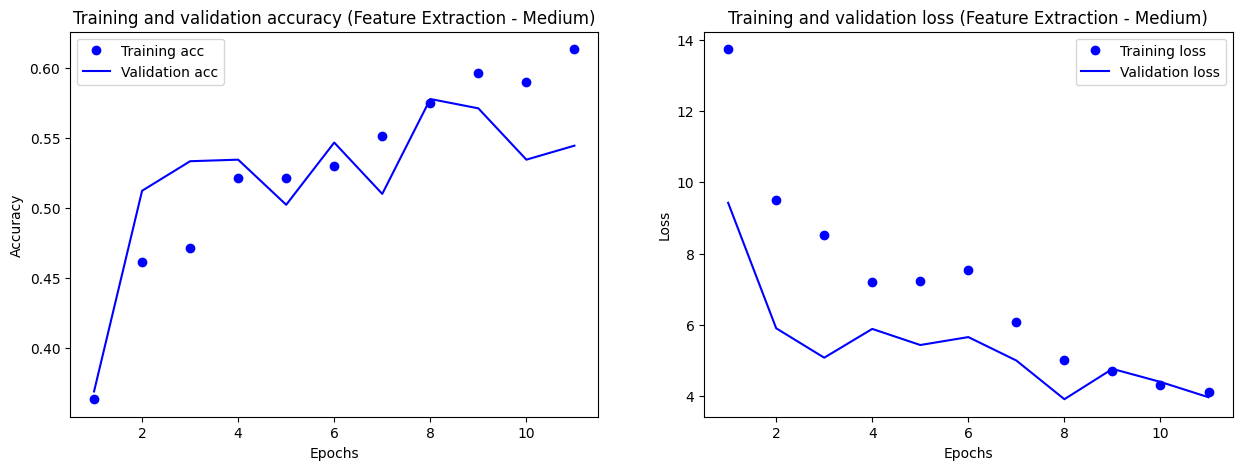

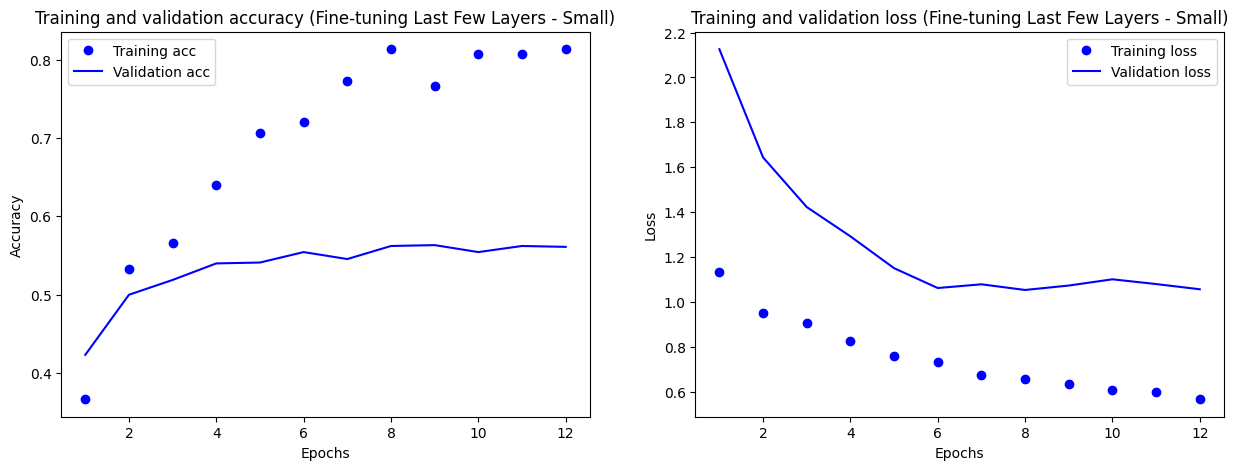

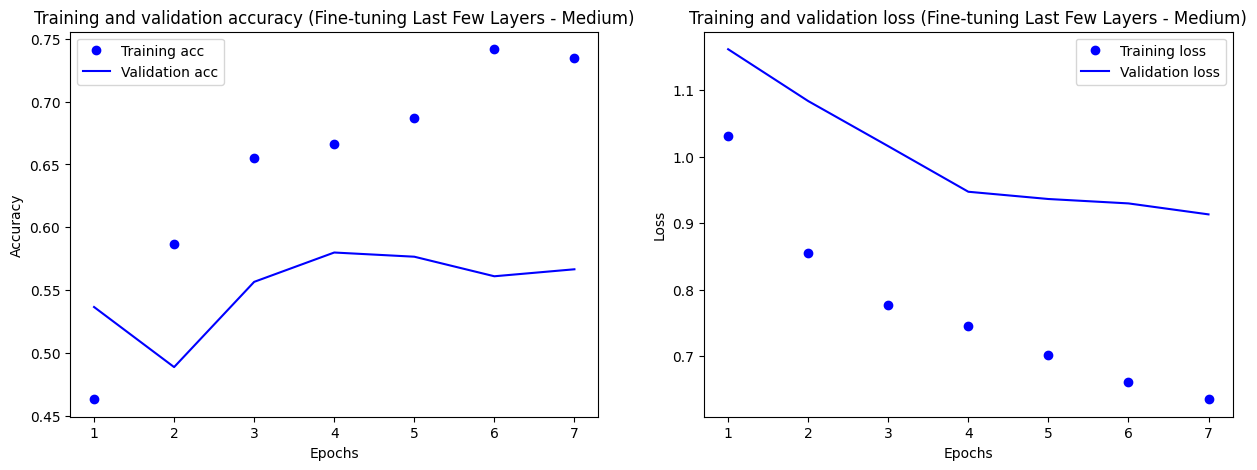

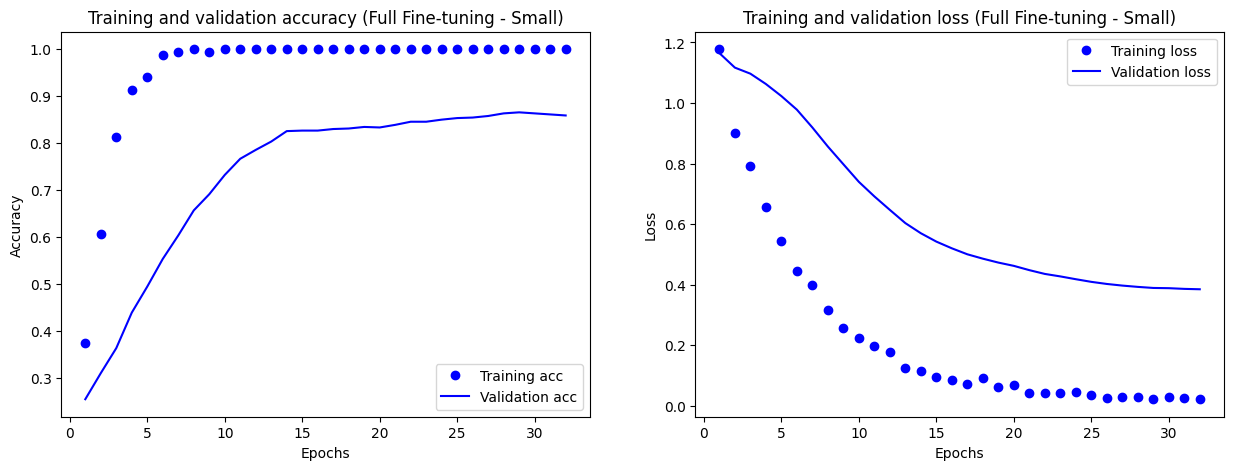

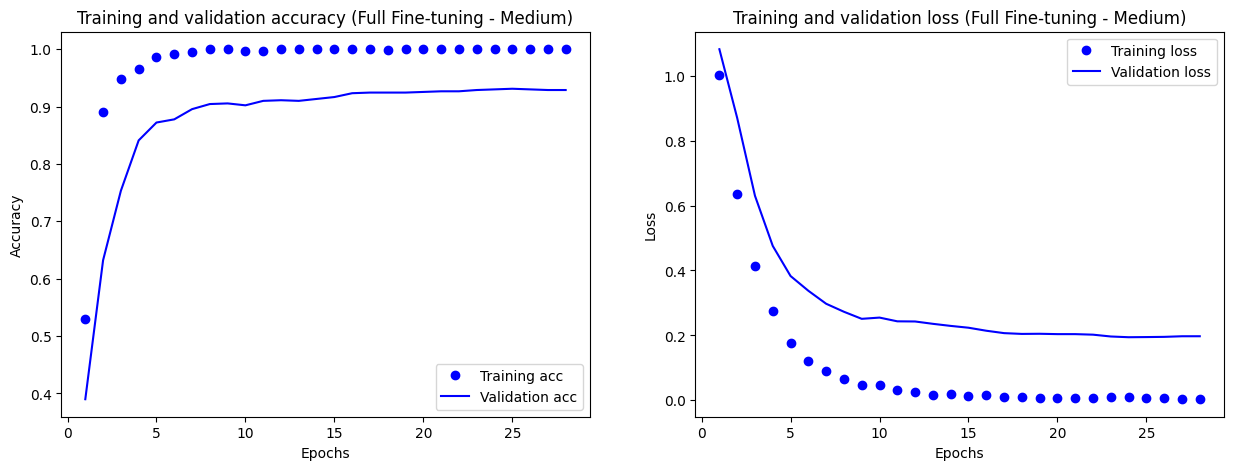

In [ ]:
# Visualize results for Feature Extraction
visualize_training_results(history_feature_medium, "Feature Extraction", "Medium")
# visualize_training_results(history_feature_full, "Feature Extraction", "Full")

# Visualize results for Fine-tuning Last Few Layers
visualize_training_results(history_finetune_small, "Fine-tuning Last Few Layers", "Small")
visualize_training_results(history_finetune_medium, "Fine-tuning Last Few Layers", "Medium")
# visualize_training_results(history_finetune_full, "Fine-tuning Last Few Layers", "Full")

# Visualize results for Full Fine-tuning
visualize_training_results(history_full_small, "Full Fine-tuning", "Small")
visualize_training_results(history_full_medium, "Full Fine-tuning", "Medium")
# visualize_training_results(history_full_full, "Full Fine-tuning", "Full")